In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q torch_geometric
!pip install -q class_resolver
!pip3 install pymatting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 6.0 MB/s eta 0:00:00


In [1]:
import numpy as np
import torch
import random
import copy
import scipy.sparse as sp

from torch.utils.data import TensorDataset, DataLoader, Subset
from torchvision import models
import torch.nn as nn
import torch.nn.functional as nnFn

# torch-geometric imports
from torch_geometric.nn import ARMAConv
from torch_geometric.data import Data
from sklearn.metrics import roc_auc_score, roc_curve


/home/snu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/snu/anaconda3/envs/torch_env/lib/python3.10/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /home/snu/anaconda3/envs/torch_env/lib/python3.10/site-packages/libpyg.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/home/snu/anaconda3/envs/torch_env/lib/python3.10/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/snu/anaconda3/envs/torch_env/lib/python3.10/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An is

In [2]:
import torch
print("CUDA available:", torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

CUDA available: True
GPU Name: NVIDIA RTX A4000


In [3]:
data = np.load('/home/snu/Downloads/breastmnist_224.npz', allow_pickle=True)

In [4]:
all_images = np.concatenate([data['train_images'], data['val_images'], data['test_images']], axis=0)
all_labels = np.concatenate([data['train_labels'], data['val_labels'], data['test_labels']], axis=0).squeeze()

images = all_images.astype(np.float32) / 255.0
images = np.repeat(images[:, None, :, :], 3, axis=1)  # (N,3,224,224)

X = torch.tensor(images)
y = torch.tensor(all_labels).long()
print("Images, labels shapes:", X.shape, y.shape)

dataset = TensorDataset(X, y)
class0_indices = [i for i in range(len(y)) if y[i] == 0]
class1_indices = [i for i in range(len(y)) if y[i] == 1]

random.seed(42)
sampled_class0 = random.sample(class0_indices, min(1000, len(class0_indices)))
sampled_class1 = random.sample(class1_indices, min(1000, len(class1_indices)))

combined_indices = sampled_class0 + sampled_class1
random.shuffle(combined_indices)

final_dataset = Subset(dataset, combined_indices)
final_loader = DataLoader(final_dataset, batch_size=64, shuffle=False)

Images, labels shapes: torch.Size([780, 3, 224, 224]) torch.Size([780])


In [5]:
import torch
import timm
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

vit = torch.hub.load('facebookresearch/dino:main', 'dino_vitb16')
vit.eval().to(device)

vit_feats = []
y_list = []

with torch.no_grad():
    for imgs, lbls in final_loader:
        imgs = imgs.to(device)
        feats = vit(imgs)
        vit_feats.append(feats.cpu())
        y_list.extend(lbls.cpu().tolist())

F = torch.cat(vit_feats, dim=0).numpy().astype(np.float32)
y_labels = np.array(y_list).astype(np.int64)

print("Feature shape:", F.shape)
print("Label shape:", y_labels.shape)
features = F

Using cache found in /home/snu/.cache/torch/hub/facebookresearch_dino_main


Feature shape: (780, 768)
Label shape: (780,)


In [6]:
def sim(h1, h2, tau=0.2):
    z1 = nnFn.normalize(h1, dim=-1, p=2)
    z2 = nnFn.normalize(h2, dim=-1, p=2)
    return torch.mm(z1, z2.t()) / tau

def contrastive_loss_wo_cross_network(h1, h2, z):
    f = lambda x: torch.exp(x)
    intra_sim = f(sim(h1, h1))
    inter_sim = f(sim(h1, h2))
    return -torch.log(inter_sim.diag() /
                     (intra_sim.sum(dim=-1) + inter_sim.sum(dim=-1) - intra_sim.diag()))

def contrastive_loss_wo_cross_view(h1, h2, z):
    f = lambda x: torch.exp(x)
    cross_sim = f(sim(h1, z))
    return -torch.log(cross_sim.diag() / cross_sim.sum(dim=-1))

In [7]:
class MLP(nn.Module):
    def __init__(self, inp_size, outp_size, hidden_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(inp_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.PReLU(), # nn.ELU()
            nn.Dropout(0.3),
            nn.Linear(hidden_size, outp_size)
        )

    def forward(self, x):
        return self.net(x)


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as nnFn
from torch_geometric.nn import ARMAConv

class ARMAEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, device, activ="RELU",
                 num_stacks=1, num_layers=1):
        super(ARMAEncoder, self).__init__()
        self.device = device

        activations = {
            "SELU": nnFn.selu,
            "SiLU": nnFn.silu,
            "GELU": nnFn.gelu,
            "ELU": nnFn.elu,
            "RELU": nnFn.relu
        }
        self.act = activations.get(activ, nnFn.elu)

        # Layer 1
        self.arma1 = ARMAConv(
            in_channels=input_dim,
            out_channels=hidden_dim,
            num_stacks=num_stacks,
            num_layers=num_layers,
            act=self.act,
            shared_weights=True,
            dropout=0.25
        )
        self.bn1 = nn.BatchNorm1d(hidden_dim)

        # Layer 2
        self.arma2 = ARMAConv(
            in_channels=hidden_dim,
            out_channels=hidden_dim,
            num_stacks=num_stacks,
            num_layers=num_layers,
            act=self.act,
            shared_weights=True,
            dropout=0.25
        )
        self.bn2 = nn.BatchNorm1d(hidden_dim)

        # Layer 3
        self.arma3 = ARMAConv(
            in_channels=hidden_dim,
            out_channels=hidden_dim,
            num_stacks=num_stacks,
            num_layers=num_layers,
            act=self.act,
            shared_weights=True,
            dropout=0.25
        )
        self.bn3 = nn.BatchNorm1d(hidden_dim)

        self.dropout = nn.Dropout(0.3)
        self.mlp = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.arma1(x, edge_index)
        x = self.bn1(x)
        x = self.act(x)
        x = self.dropout(x)

        x = self.arma2(x, edge_index)
        x = self.bn2(x)
        x = self.act(x)
        x = self.dropout(x)

        x = self.arma3(x, edge_index)
        x = self.bn3(x)
        x = self.act(x)
        x = self.dropout(x)

        logits = self.mlp(x)
        return logits


In [9]:
class EMA():  # Moving Average update
    def __init__(self, beta):
        super().__init__()
        self.beta = beta

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

def update_moving_average(ema_updater, ma_model, current_model):
    for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
        old_weight, up_weight = ma_params.data, current_params.data
        ma_params.data = ema_updater.update_average(old_weight, up_weight)

In [10]:
class ARMA(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_clusters, device, activ, moving_average_decay=0.5, cut=True):
        super(ARMA, self).__init__()
        self.device = device
        self.num_clusters = num_clusters
        self.cut = cut
        self.beta = 0.6

        self.online_encoder = ARMAEncoder(input_dim, hidden_dim, device, activ)
        self.target_encoder = copy.deepcopy(self.online_encoder)

        activations = {
            "SELU": nnFn.selu,
            "SiLU": nnFn.silu,
            "GELU": nnFn.gelu,
            "RELU": nnFn.relu
        }
        self.act = activations.get(activ, nnFn.elu)
        self.online_predictor = MLP(hidden_dim, num_clusters, hidden_dim)
        self.loss = self.cut_loss if cut else self.modularity_loss
        self.target_ema_updater = EMA(moving_average_decay)

    def reset_moving_average(self):
        del self.target_encoder
        self.target_encoder = None

    def update_ma(self):
        assert self.target_encoder is not None, 'target encoder has not been created yet'
        update_moving_average(self.target_ema_updater, self.target_encoder, self.online_encoder)

    def forward(self, data1, data2):
        x1 = self.online_encoder(data1)
        logits1 = self.online_predictor(x1)
        S1 = nnFn.softmax(logits1, dim=1)

        x2 = self.online_encoder(data2)
        logits2 = self.online_predictor(x2)
        S2 = nnFn.softmax(logits2, dim=1)

        with torch.no_grad():
            target_proj_one = self.target_encoder(data1).detach()
            target_proj_two = self.target_encoder(data2).detach()

        l1 = self.beta * contrastive_loss_wo_cross_network(x1, x2, target_proj_two) + \
             (1.0 - self.beta) * contrastive_loss_wo_cross_view(x1, x2, target_proj_two)

        l2 = self.beta * contrastive_loss_wo_cross_network(x2, x1, target_proj_one) + \
             (1.0 - self.beta) * contrastive_loss_wo_cross_view(x2, x1, target_proj_one)

        return S1, S2, logits1, logits2, l1, l2

    def modularity_loss(self, A, S):
        C = nnFn.softmax(S, dim=1)
        d = torch.sum(A, dim=1)
        m = torch.sum(A)
        B = A - torch.ger(d, d) / (2 * m)

        I_S = torch.eye(self.num_clusters, device=self.device)
        k = torch.tensor(self.num_clusters, dtype=torch.float32, device=self.device)
        n = S.shape[0]

        modularity_term = (-1 / (2 * m)) * torch.trace(torch.mm(torch.mm(C.t(), B), C))
        collapse_reg_term = (torch.sqrt(k) / n) * torch.norm(torch.sum(C, dim=0), p='fro') - 1

        return modularity_term + collapse_reg_term

    def cut_loss(self, A, S):
        S = nnFn.softmax(S, dim=1)
        A_pool = torch.matmul(torch.matmul(A, S).t(), S)
        num = torch.trace(A_pool)

        D = torch.diag(torch.sum(A, dim=-1))
        D_pooled = torch.matmul(torch.matmul(D, S).t(), S)
        den = torch.trace(D_pooled)
        mincut_loss = -(num / den)

        St_S = torch.matmul(S.t(), S)
        I_S = torch.eye(self.num_clusters, device=self.device)
        ortho_loss = torch.norm(St_S / torch.norm(St_S) - I_S / torch.norm(I_S))

        return mincut_loss + ortho_loss

In [11]:
def create_adj(features, cut, alpha=1.0):
    """Return a dense W0 matrix (only once), as you originally used for A1 / unsup loss.
       We still create the dense matrix once, but all augmentations below work with edge_index.
    """
    F_norm = features / np.linalg.norm(features, axis=1, keepdims=True)
    W = np.dot(F_norm, F_norm.T)

    if cut == 0:
        W = np.where(W >= alpha, 1, 0).astype(np.float32)
        W = (W / W.max()).astype(np.float32)
    else:
        W = (W * (W >= alpha)).astype(np.float32)
    return W

In [12]:
def edge_index_from_dense(W):
    """Return edge_index as numpy array shape (2, E) and edge_weight vector."""
    rows, cols = np.nonzero(W > 0)
    edge_index = np.vstack([rows, cols]).astype(np.int64)
    edge_weight = W[rows, cols].astype(np.float32)
    return edge_index, edge_weight

In [13]:
def build_adj_list(edge_index_np, num_nodes):
    """Build adjacency list: list of neighbor arrays for each node (numpy)."""
    adj = [[] for _ in range(num_nodes)]
    src = edge_index_np[0]
    dst = edge_index_np[1]
    for s, d in zip(src, dst):
        adj[s].append(d)
    # convert to numpy arrays for speed
    adj = [np.array(neis, dtype=np.int64) if len(neis) > 0 else np.array([], dtype=np.int64) for neis in adj]
    return adj

In [14]:
def aug_random_edge_edge_index(edge_index_np, drop_percent=0.2, seed=None):
    """Randomly drop edges from edge_index. Returns new edge_index (2 x E') and edge_weight placeholder."""
    rng = np.random.default_rng(seed)
    E = edge_index_np.shape[1]
    keep_mask = rng.random(E) >= drop_percent
    new_edge_index = edge_index_np[:, keep_mask]
    return new_edge_index

In [15]:
def aug_subgraph_edge_index(features_np, edge_index_np, adj_list, drop_percent=0.2, seed=None):
    """
    Sample a subgraph by selecting s_node_num nodes via neighbor expansion (BFS-like),
    then return (sub_features, sub_edge_index) with node ids remapped to [0..s-1].
    """
    rng = np.random.default_rng(seed)
    num_nodes = features_np.shape[0]
    s_node_num = int(num_nodes * (1 - drop_percent))
    if s_node_num < 1:
        s_node_num = 1

    # choose a random center node
    center_node = int(rng.integers(0, num_nodes))
    sub_nodes = [center_node]
    front_idx = 0

    # BFS-like expansion using adjacency list until we reach s_node_num
    while len(sub_nodes) < s_node_num and front_idx < len(sub_nodes):
        cur = sub_nodes[front_idx]
        neighbors = adj_list[cur]
        if neighbors.size > 0:
            # shuffle neighbors and try to add new ones
            nbrs_shuffled = neighbors.copy()
            rng.shuffle(nbrs_shuffled)
            for nb in nbrs_shuffled:
                if nb not in sub_nodes:
                    sub_nodes.append(int(nb))
                    if len(sub_nodes) >= s_node_num:
                        break
        front_idx += 1
        # if BFS stalls (no new neighbors), add random nodes
        if front_idx >= len(sub_nodes) and len(sub_nodes) < s_node_num:
            remaining = [n for n in range(num_nodes) if n not in sub_nodes]
            if not remaining:
                break
            add = int(rng.choice(remaining))
            sub_nodes.append(add)

    sub_nodes = sorted(set(sub_nodes))
    node_map = {old: new for new, old in enumerate(sub_nodes)}

    # induce edges that have both ends in sub_nodes
    src = edge_index_np[0]
    dst = edge_index_np[1]
    mask_src_in = np.isin(src, sub_nodes)
    mask_dst_in = np.isin(dst, sub_nodes)
    mask = mask_src_in & mask_dst_in
    sel_src = src[mask]
    sel_dst = dst[mask]
    # remap
    remapped_src = np.array([node_map[int(s)] for s in sel_src], dtype=np.int64)
    remapped_dst = np.array([node_map[int(d)] for d in sel_dst], dtype=np.int64)
    new_edge_index = np.vstack([remapped_src, remapped_dst])
    # sub features
    sub_features = features_np[sub_nodes, :].astype(np.float32)
    return sub_features, new_edge_index

In [16]:
def load_data_from_edge_index(node_feats_np, edge_index_np, device):
    """Return PyG Data with torch tensors. edge_index_np is (2, E) numpy."""
    node_feats = torch.from_numpy(node_feats_np).float()
    edge_index = torch.from_numpy(edge_index_np.astype(np.int64)).long()
    return node_feats, edge_index

In [48]:
# # Required Parameters
# cut = 0 # Consider n-cut loss OR Modularity loss (by default cut = 0)
# alpha = 0.75 # Edge creation Threshold
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# K = 2  # Number of clusters
# np.random.seed(42)
# # Define all activation functions to test
# define_activations = ["SELU", "SiLU", "GELU", "ELU", "RELU"]
# activ = "RELU"
# num_epochs = 5000
# base_seed = 42
# lambda_contrastive = 0.005
# feats_dim = features.shape[1]

In [17]:
# Required Parameters
cut = 0 # Consider n-cut loss OR Modularity loss (by default cut = 0)
alpha = 0.73 # Edge creation Threshold
device = 'cuda' if torch.cuda.is_available() else 'cpu'
K = 2  # Number of clusters
np.random.seed(42)
# Define all activation functions to test
define_activations = ["SELU", "SiLU", "GELU", "ELU", "RELU"]
activ = "RELU"
num_epochs = 5000
base_seed = 42
lambda_contrastive = 0.005
feats_dim = features.shape[1]

In [18]:
W0 = create_adj(features, cut, alpha)  # shape (N, N) dense
A1 = torch.from_numpy(W0).float().to(device)

edge_index_np, edge_weight_np = edge_index_from_dense(W0)  # numpy edge_index (2, E)
num_nodes = features.shape[0]
adj_list = build_adj_list(edge_index_np, num_nodes)  # adjacency list for fast subgraph sampling

# convert features to numpy (we'll slice them in augmentations)
features_np = features.copy()

# Build initial Data object (full graph)
node_feats_full, edge_index_full = load_data_from_edge_index(features_np, edge_index_np, device)
data0 = Data(x=node_feats_full.to(device), edge_index=edge_index_full.to(device))
print("Data0:", data0)

Data0: Data(x=[780, 768], edge_index=[2, 266936])


In [20]:
from torch.optim.lr_scheduler import StepLR
from torch.optim import AdamW

In [28]:
from torch.optim.lr_scheduler import StepLR
from torch.optim import AdamW

feats_dim = features.shape[1]
model = ARMA(feats_dim, 256, K, device, activ, cut).to(device)
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=200, gamma=0.5)

# Seeds
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Training hyperparams (you can reduce num_epochs for debugging)
num_epochs = 2500
lambda_contrastive = 0.001

for epoch in range(num_epochs):
    # --- Augmentations using edge_index or adjacency list (fast, sparse) ---
    # 1) Random edge drop on edge_index
    W_aug1_edge_index = aug_random_edge_edge_index(edge_index_np, drop_percent=0.2, seed=epoch)

    # 2) Subgraph via adjacency list (returns sub_features and sub_edge_index)
    W_aug2_edge_index = aug_random_edge_edge_index(edge_index_np, drop_percent=0.2, seed=epoch + 999)
    features_aug2 = features_np.copy()

    # 3) Feature augmentations (keep these as numpy operations)
    # Feature dropout (column-wise)
    rng = np.random.default_rng(epoch)
    mask = rng.random(features_np.shape) >= 0.2
    features_aug1 = (features_np * mask.astype(np.float32))

    # Feature cell dropout (random cell zeroing)
    aug_feat2 = features_np.copy()
    num_nodes_local, feat_dim = aug_feat2.shape
    drop_feat_num = int(num_nodes_local * feat_dim * 0.2)
    # random positions to zero
    flat_idx = rng.choice(num_nodes_local * feat_dim, size=drop_feat_num, replace=False)
    rows = (flat_idx // feat_dim)
    cols = (flat_idx % feat_dim)
    aug_feat2[rows, cols] = 0.0
    features_aug2_feat = aug_feat2.astype(np.float32)

    # --- Build PyG Data objects for the two views ---
    # view1: features_aug1 with W_aug1_edge_index
    node_feats1, edge_index1 = load_data_from_edge_index(features_aug1, W_aug1_edge_index, device)
    data1 = Data(x=node_feats1.to(device), edge_index=edge_index1.to(device))

    # view2: features_aug2 (from subgraph) and its edge_index
    node_feats2, edge_index2 = load_data_from_edge_index(features_aug2, W_aug2_edge_index, device)
    data2 = Data(x=node_feats2.to(device), edge_index=edge_index2.to(device))

    # --- Training step ---
    model.train()
    optimizer.zero_grad()

    S1, S2, logits1, logits2, l1, l2 = model(data1, data2)

    unsup_loss = model.loss(A1, logits1)
    cont_loss = ((l1 + l2) / 2).mean()
    total_loss = unsup_loss + lambda_contrastive * cont_loss

    total_loss.backward()
    optimizer.step()
    scheduler.step()
    model.update_ma()

    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Total: {total_loss.item():.4f} | Unsup: {unsup_loss.item():.4f} | Cont: {cont_loss.item():.4f}")

Epoch 0 | Total: -0.2272 | Unsup: -0.2343 | Cont: 7.1084


KeyboardInterrupt: 

In [22]:
model.eval()
with torch.no_grad():
    S1, _, logits1, _, _, _ = model(data0, data0)
    y_pred_proba = nnFn.softmax(logits1, dim=1).cpu().numpy()
    y_pred = np.argmax(y_pred_proba, axis=1)

In [23]:
print(y_pred[:20])
print(y_pred_proba.max(axis=-1)[:20])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0.99999964 0.9999999  0.99999976 0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.99999964 0.99999976 0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999 ]


In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
acc_score = accuracy_score(y_labels, y_pred)
acc_score_inverted = accuracy_score(y_labels, 1 - y_pred)
if acc_score_inverted > acc_score:
    acc_score = acc_score_inverted
    y_pred = 1 - y_pred

prec_score = precision_score(y_labels, y_pred)
rec_score = recall_score(y_labels, y_pred)
f1 = f1_score(y_labels, y_pred)
log_loss_value = log_loss(y_labels, y_pred_proba)

print("Accuracy Score:", acc_score)
print("Precision Score:", prec_score)
print("Recall Score:", rec_score)
print("F1 Score:", f1)
print("Log Loss:", log_loss_value)

Accuracy Score: 0.7307692307692307
Precision Score: 0.7307692307692307
Recall Score: 1.0
F1 Score: 0.8444444444444444
Log Loss: 4.240269390023067


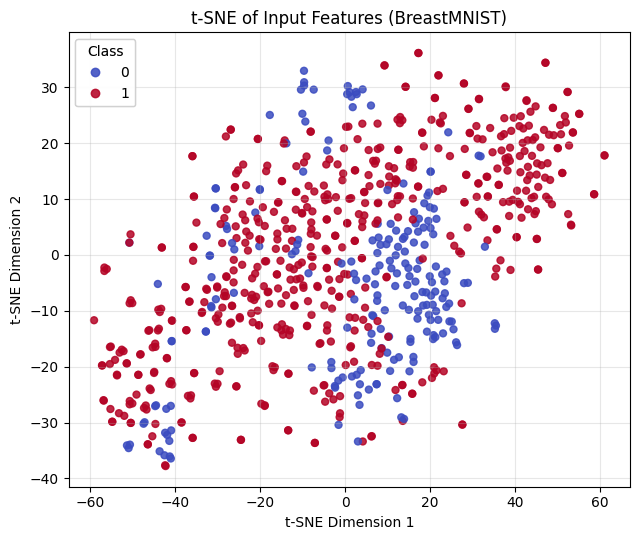

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# ---- Input features ----
X_input = features

# ---- Labels ----
labels = y_labels

# ---- Run t-SNE on input features ----
tsne_input = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    init="pca",
    random_state=42
)

X_2d = tsne_input.fit_transform(X_input)

# ---- Plot t-SNE (Input Space) ----
plt.figure(figsize=(6.5, 5.5))

scatter = plt.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=labels,
    cmap="coolwarm",
    s=25,
    alpha=0.85
)

# ---- Legend ----
legend = plt.legend(
    *scatter.legend_elements(),
    title="Class",
    loc="best"
)
plt.gca().add_artist(legend)

# ---- Formatting ----
plt.title("t-SNE of Input Features (BreastMNIST)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()


In [50]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss

NUM_RUNS = 10

acc_list = []
prec_list = []
rec_list = []
f1_list = []
logloss_list = []

for run in range(NUM_RUNS):
    print(f"\n===== RUN {run+1}/{NUM_RUNS} =====")

    from torch.optim.lr_scheduler import StepLR
    from torch.optim import AdamW

    feats_dim = features.shape[1]
    model = ARMA(feats_dim, 256, K, device, activ, cut).to(device)
    optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = StepLR(optimizer, step_size=200, gamma=0.5)

    # Seeds
    np.random.seed(42 + run)
    random.seed(42 + run)
    torch.manual_seed(42 + run)

    num_epochs = 2500
    lambda_contrastive = 0.001

    for epoch in range(num_epochs):
        # -------- augmentations --------
        W_aug1_edge_index = aug_random_edge_edge_index(edge_index_np, drop_percent=0.2, seed=epoch)
        W_aug2_edge_index = aug_random_edge_edge_index(edge_index_np, drop_percent=0.2, seed=epoch + 999)

        rng = np.random.default_rng(epoch)
        mask = rng.random(features_np.shape) >= 0.2
        features_aug1 = (features_np * mask.astype(np.float32))

        aug_feat2 = features_np.copy()
        n_nodes, feat_dim = aug_feat2.shape
        drop_feat_num = int(n_nodes * feat_dim * 0.2)
        flat_idx = rng.choice(n_nodes * feat_dim, size=drop_feat_num, replace=False)
        rows = flat_idx // feat_dim
        cols = flat_idx % feat_dim
        aug_feat2[rows, cols] = 0.0
        features_aug2 = aug_feat2.astype(np.float32)

        node_feats1, edge_index1 = load_data_from_edge_index(features_aug1, W_aug1_edge_index, device)
        data1 = Data(x=node_feats1.to(device), edge_index=edge_index1.to(device))

        node_feats2, edge_index2 = load_data_from_edge_index(features_aug2, W_aug2_edge_index, device)
        data2 = Data(x=node_feats2.to(device), edge_index=edge_index2.to(device))

        # -------- training --------
        model.train()
        optimizer.zero_grad()

        S1, S2, logits1, logits2, l1, l2 = model(data1, data2)

        unsup_loss = model.loss(A1, logits1)
        cont_loss = ((l1 + l2) / 2).mean()
        total_loss = unsup_loss + lambda_contrastive * cont_loss

        total_loss.backward()
        optimizer.step()
        scheduler.step()
        model.update_ma()

        if epoch % 100 == 0:
            print(f"Epoch {epoch} | Total: {total_loss.item():.4f} "
                  f"| Unsup: {unsup_loss.item():.4f} | Cont: {cont_loss.item():.4f}")

    # -------- evaluation --------
    model.eval()
    with torch.no_grad():
        S1, _, logits1, _, _, _ = model(data0, data0)
        y_pred_proba = nnFn.softmax(logits1, dim=1).cpu().numpy()
        y_pred = np.argmax(y_pred_proba, axis=1)

    acc = accuracy_score(y_labels, y_pred)
    acc_inv = accuracy_score(y_labels, 1 - y_pred)
    if acc_inv > acc:   # flip if class labels reversed
        acc = acc_inv
        y_pred = 1 - y_pred

    prec = precision_score(y_labels, y_pred)
    rec = recall_score(y_labels, y_pred)
    f1 = f1_score(y_labels, y_pred)
    ll = log_loss(y_labels, y_pred_proba)

    acc_list.append(acc)
    prec_list.append(prec)
    rec_list.append(rec)
    f1_list.append(f1)
    logloss_list.append(ll)

# -------- mean ± std printing --------
def mean_std(a):
    return np.mean(a), np.std(a)

print("\n===== FINAL RESULTS OVER 10 RUNS =====")
m, s = mean_std(acc_list);     print(f"Accuracy: {m:.4f} ± {s:.4f}")
m, s = mean_std(prec_list);    print(f"Precision: {m:.4f} ± {s:.4f}")
m, s = mean_std(rec_list);     print(f"Recall: {m:.4f} ± {s:.4f}")
m, s = mean_std(f1_list);      print(f"F1: {m:.4f} ± {s:.4f}")
m, s = mean_std(logloss_list); print(f"Log Loss: {m:.4f} ± {s:.4f}")



===== RUN 1/10 =====
Epoch 0 | Total: -0.2449 | Unsup: -0.2520 | Cont: 7.0768
Epoch 100 | Total: -0.5804 | Unsup: -0.5874 | Cont: 6.9293
Epoch 200 | Total: -0.6207 | Unsup: -0.6275 | Cont: 6.7931
Epoch 300 | Total: -0.6285 | Unsup: -0.6352 | Cont: 6.6989
Epoch 400 | Total: -0.6374 | Unsup: -0.6441 | Cont: 6.6548
Epoch 500 | Total: -0.6408 | Unsup: -0.6474 | Cont: 6.6060
Epoch 600 | Total: -0.6378 | Unsup: -0.6444 | Cont: 6.6207
Epoch 700 | Total: -0.6468 | Unsup: -0.6534 | Cont: 6.5627
Epoch 800 | Total: -0.6479 | Unsup: -0.6545 | Cont: 6.5661
Epoch 900 | Total: -0.6468 | Unsup: -0.6533 | Cont: 6.5583
Epoch 1000 | Total: -0.6404 | Unsup: -0.6469 | Cont: 6.5337
Epoch 1100 | Total: -0.6427 | Unsup: -0.6492 | Cont: 6.5206
Epoch 1200 | Total: -0.6477 | Unsup: -0.6543 | Cont: 6.5365
Epoch 1300 | Total: -0.6455 | Unsup: -0.6520 | Cont: 6.5574
Epoch 1400 | Total: -0.6392 | Unsup: -0.6457 | Cont: 6.5196
Epoch 1500 | Total: -0.6466 | Unsup: -0.6532 | Cont: 6.5333
Epoch 1600 | Total: -0.6442 | 

alpha = 0.2, Accuracy 0.725 $\pm$ 0.01 & Precision 0.733 $\pm$ 0.00 & Recall 0.982 $\pm$ 0.01 & F1 0.839 $\pm$ 0.00 \
alpha = 0.4
Accuracy: 0.7208 ± 0.0000
Precision: 0.7208 ± 0.0000
Recall: 1.0000 ± 0.0000
F1: 0.8444 ± 0.0000 \
alpha = 0.75
Accuracy: 0.7155 ± 0.0101
Precision: 0.7308 ± 0.0029
Recall: 0.9668 ± 0.0144
F1: 0.8324 ± 0.0070 \
alpha = 0.8
Accuracy: 0.7012 ± 0.0144
Precision: 0.7337 ± 0.0043
Recall: 0.9277 ± 0.0249
F1: 0.8193 ± 0.0111 \
alpha = 0.85
Accuracy: 0.6400 ± 0.0201
Precision: 0.7151 ± 0.0113
Recall: 0.8433 ± 0.0183
F1: 0.7739 ± 0.0133

In [22]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss

num_runs = 10
num_epochs = 5000
lr = 1e-4
weight_decay = 1e-4
lambda_list = [0.001, 0.01, 0.5, 0.9, 2]
base_seed = 42

all_results = []

for lam in lambda_list:
    print(f"\n================ LAMBDA = {lam} ================\n")

    acc_scores, prec_scores, rec_scores, f1_scores, log_losses = [], [], [], [], []

    for run in range(num_runs):
        print(f"\n--- Run {run + 1}/{num_runs} ---")
        torch.manual_seed(base_seed + run)
        np.random.seed(base_seed + run)
        random.seed(base_seed + run)

        # --- Model Setup ---
        model = ARMA(feats_dim, 256, K, device, activ, cut).to(device)
        optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = StepLR(optimizer, step_size=200, gamma=0.5)

        for epoch in range(num_epochs):
            # 1) Two random edge augmentations
            W_aug1_edge_index = aug_random_edge_edge_index(edge_index_np, drop_percent=0.2, seed=epoch)
            W_aug2_edge_index = aug_random_edge_edge_index(edge_index_np, drop_percent=0.2, seed=epoch + 999)

            # 2) Feature augmentations
            rng = np.random.default_rng(epoch)
            mask = rng.random(features_np.shape) >= 0.2
            features_aug1 = (features_np * mask.astype(np.float32))
            features_aug2 = features_np.copy()
            num_nodes_local, feat_dim = features_aug2.shape
            drop_feat_num = int(num_nodes_local * feat_dim * 0.2)
            flat_idx = rng.choice(num_nodes_local * feat_dim, size=drop_feat_num, replace=False)
            rows = (flat_idx // feat_dim)
            cols = (flat_idx % feat_dim)
            features_aug2[rows, cols] = 0.0
            features_aug2_feat = features_aug2.astype(np.float32)

            # 3) Build Data views
            node_feats1, edge_index1 = load_data_from_edge_index(features_aug1, W_aug1_edge_index, device)
            data1 = Data(x=node_feats1.to(device), edge_index=edge_index1.to(device))
            node_feats2, edge_index2 = load_data_from_edge_index(features_aug2_feat, W_aug2_edge_index, device)
            data2 = Data(x=node_feats2.to(device), edge_index=edge_index2.to(device))

            # --- Training step ---
            model.train()
            optimizer.zero_grad()

            S1, S2, logits1, logits2, l1, l2 = model(data1, data2)
            unsup_loss = model.loss(A1, logits1)
            cont_loss = ((l1 + l2) / 2).mean()
            total_loss = unsup_loss + lam * cont_loss

            total_loss.backward()
            optimizer.step()
            scheduler.step()
            model.update_ma()

            if epoch % 500 == 0:
                print(f"Epoch {epoch} | Total: {total_loss.item():.4f} | Unsup: {unsup_loss.item():.4f} | Cont: {cont_loss.item():.4f}")

        # --- Evaluation ---
        model.eval()
        with torch.no_grad():
            S1, _, logits1, _, _, _ = model(data0, data0)
            y_pred_proba = nnFn.softmax(logits1, dim=1).cpu().numpy()
            y_pred = np.argmax(y_pred_proba, axis=1)

        acc = accuracy_score(y_labels, y_pred)
        acc_inv = accuracy_score(y_labels, 1 - y_pred)
        if acc_inv > acc:
            acc = acc_inv
            y_pred = 1 - y_pred

        prec = precision_score(y_labels, y_pred)
        rec = recall_score(y_labels, y_pred)
        f1 = f1_score(y_labels, y_pred)
        ll = log_loss(y_labels, y_pred_proba)

        acc_scores.append(acc)
        prec_scores.append(prec)
        rec_scores.append(rec)
        f1_scores.append(f1)
        log_losses.append(ll)

        print(f"Run {run + 1} Accuracy: {acc:.4f}, F1: {f1:.4f}")

    # --- Aggregate Results ---
    lambda_results = {
        "lambda": lam,
        "accuracy": (np.mean(acc_scores), np.std(acc_scores)),
        "precision": (np.mean(prec_scores), np.std(prec_scores)),
        "recall": (np.mean(rec_scores), np.std(rec_scores)),
        "f1": (np.mean(f1_scores), np.std(f1_scores)),
        "log_loss": (np.mean(log_losses), np.std(log_losses))
    }
    all_results.append(lambda_results)

    print(f"\n--- RESULTS FOR LAMBDA = {lam} ---")
    print(f"Accuracy: {lambda_results['accuracy'][0]:.4f} ± {lambda_results['accuracy'][1]:.4f}")
    print(f"Precision: {lambda_results['precision'][0]:.4f} ± {lambda_results['precision'][1]:.4f}")
    print(f"Recall: {lambda_results['recall'][0]:.4f} ± {lambda_results['recall'][1]:.4f}")
    print(f"F1 Score: {lambda_results['f1'][0]:.4f} ± {lambda_results['f1'][1]:.4f}")
    print(f"Log Loss: {lambda_results['log_loss'][0]:.4f} ± {lambda_results['log_loss'][1]:.4f}")

# ==========================================================
# === Final Summary ===
# ==========================================================
print("\n================ FINAL SUMMARY FOR ALL LAMBDAS ================\n")
print(f"{'Lambda':>8} | {'Accuracy':>18} | {'Precision':>18} | {'Recall':>18} | {'F1 Score':>18} | {'Log Loss':>18}")
print("-" * 108)
for res in all_results:
    print(f"{res['lambda']:>8} | "
          f"{res['accuracy'][0]:.4f} ± {res['accuracy'][1]:.4f} | "
          f"{res['precision'][0]:.4f} ± {res['precision'][1]:.4f} | "
          f"{res['recall'][0]:.4f} ± {res['recall'][1]:.4f} | "
          f"{res['f1'][0]:.4f} ± {res['f1'][1]:.4f} | "
          f"{res['log_loss'][0]:.4f} ± {res['log_loss'][1]:.4f}")


================ LAMBDA = 0.001 ================


--- Run 1/10 ---
Epoch 0 | Total: -0.2434 | Unsup: -0.2505 | Cont: 7.0886
Epoch 500 | Total: -0.5857 | Unsup: -0.5925 | Cont: 6.7341
Epoch 1000 | Total: -0.5939 | Unsup: -0.6006 | Cont: 6.6621
Epoch 1500 | Total: -0.5904 | Unsup: -0.5970 | Cont: 6.6612
Epoch 2000 | Total: -0.5895 | Unsup: -0.5961 | Cont: 6.6440
Epoch 2500 | Total: -0.5893 | Unsup: -0.5959 | Cont: 6.6022
Epoch 3000 | Total: -0.5948 | Unsup: -0.6014 | Cont: 6.6343
Epoch 3500 | Total: -0.5891 | Unsup: -0.5958 | Cont: 6.6413
Epoch 4000 | Total: -0.5913 | Unsup: -0.5979 | Cont: 6.6399
Epoch 4500 | Total: -0.5945 | Unsup: -0.6011 | Cont: 6.6420
Run 1 Accuracy: 0.7308, F1: 0.8428

--- Run 2/10 ---
Epoch 0 | Total: -0.2427 | Unsup: -0.2498 | Cont: 7.0797
Epoch 500 | Total: -0.5829 | Unsup: -0.5896 | Cont: 6.6927
Epoch 1000 | Total: -0.5925 | Unsup: -0.5991 | Cont: 6.6458
Epoch 1500 | Total: -0.5924 | Unsup: -0.5991 | Cont: 6.6279
Epoch 2000 | Total: -0.5916 | Unsup: -0.5983 |